# Example: Feature Selection -  Predicting Survival of Titanic Passengers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx

import dynex
import dimod

This notebook demonstrates the formulation of an $\left(\frac{n}{k}\right)$ optimization problem to be computed on the Dynex neuromorphic platform. The method used in the example problem of this notebook —feature-selection for machine learning— is applicable to problems from a wide range of domains; for example financial portfolio optimization. This notebook should help you understand both the techniques and Dimod tools used for solving optimization problems on the Dynex computing platform.

## What is Feature Selection? 

Statistical and machine-learning models use sets of input variables ("features") to predict output variables of interest. Feature selection can be part of the model design process: selecting from a large set of potential features a highly informative subset simplifies the model and reduces dimensionality.

For example, to build a model that predicts the ripening of hothouse tomatoes, Farmer MacDonald daily records the date, noontime temperature, daylight hours, degree of cloudiness, rationed water and fertilizer, soil humidity, electric-light hours, etc. These measurements constitute a list of potential features. After a growth cycle or two, her analysis reveals some correlations between these features and crop yields:

- fertilizer seems a strong predictor of fruit size
- cloudiness and daylight hours seem poor predictors of growth
- water rations and soil humidity seem a highly correlated pair of strong predictors of crop rot

Farmer MacDonald suspects that her hothouse's use of electric light reduces dependency on seasons and sunlight. She can simplify her model by discarding date, daylight hours, and cloudiness. She can record just water ration or just soil humidity rather than both.

For systems with large numbers of potential input information—for example, weather forecasting or image recognition—model complexity and required compute resources can be daunting. Feature selection can help make such models tractable.

However, optimal feature selection can itself be a hard problem. This example introduces a powerful method of optimizing feature selection based on a complex probability calculation. This calculation is submitted for solution to a quantum computer.

## Feature Selection by Mutual Information

There are various methods for feature selection. If you are building a machine-learning model, for example, and have six potential features, you might naively consider training it first on each of the features by itself, then on all 15 combinations of subsets of two features, then 20 combinations of subsets of three features, and so on. However, statistical methods are more efficient.

One statistical criterion that can guide this selection is mutual information (MI).The following section explains information and MI based on the Titanic dataset.

Mutual information between variables X and Y is defined as

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>I</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>;</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <munder>
    <mo data-mjx-texclass="OP">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>y</mi>
      <mo>&#x2208;</mo>
      <mi>Y</mi>
    </mrow>
  </munder>
  <munder>
    <mo data-mjx-texclass="OP">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>x</mi>
      <mo>&#x2208;</mo>
      <mi>X</mi>
    </mrow>
  </munder>
  <mi>p</mi>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo>,</mo>
  <mi>y</mi>
  <mo stretchy="false">)</mo>
  <mi>log</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mfrac>
    <mrow>
      <mi>p</mi>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo>,</mo>
      <mi>y</mi>
      <mo stretchy="false">)</mo>
    </mrow>
    <mrow>
      <mi>p</mi>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo stretchy="false">)</mo>
      <mi>p</mi>
      <mo stretchy="false">(</mo>
      <mi>y</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </mfrac>
</math>

where p(x) and p(y)are marginal probabilities of X and Y, and p(y,y) the joint probability. Equivalently,

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>I</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>;</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <mi>Y</mi>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <mi>Y</mi>
  <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
  <mi>X</mi>
  <mo stretchy="false">)</mo>
</math>

where H(Y) is the SE of Y and H(Y|X) is the CSE of Y conditional on X.

Mutual information (MI) quantifies how much one knows about one random variable from observations of another. Intuitively, a model based on just one of a pair of features (e.g., farmer MacDonald's water rations and soil humidity) will better reproduce their combined contribution when MI between them is high.

## Helper Functions (MI and Plotting) 

The following cells are implementing the MI calculations as well as some functions to plot data:

In [2]:
# Define MI calculations
def prob(dataset):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [len(np.unique(dataset[:, ci])) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)


def shannon_entropy(p):
    """Shannon entropy H(X) is the negative sum of P(X)log(P(X)) for probability
    distribution P(X).
    """
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)


def conditional_shannon_entropy(p, *conditional_indices):
    """Conditional Shannon entropy H(X|Y) = H(X,Y) - H(Y)."""

    # Sanity check on validity of conditional_indices.  In particular,
    # try to trap issues in which dimensions have been removed from
    # probability table through marginalization, but
    # conditional_indices were not updated accordingly.
    assert(all(ci < p.ndim for ci in conditional_indices))

    axis = tuple(i for i in np.arange(len(p.shape))
                 if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

def mutual_information(prob, j):
    """Mutual information between variables X and variable Y.

    Calculated as I(X; Y) = H(X) - H(X|Y)."""

    return (shannon_entropy(np.sum(prob, axis=j))
            - conditional_shannon_entropy(prob, j))

In [3]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.

    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    # Compute an updated version of the conditional indices for use
    # when the probability table is marginalized over dimension j.
    # This marginalization removes one dimension, so any conditional
    # indices pointing to dimensions after this one must be adjusted
    # accordingly.
    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))


def maximum_energy_delta(bqm):
    """Compute conservative bound on maximum change in energy when flipping a single variable"""
    return max(abs(bqm.get_linear(i))
               + sum(abs(bqm.get_quadratic(i,j))
                     for j, _ in bqm.iter_neighborhood(i))
               for i in bqm.variables)


def mutual_information_bqm(dataset, features, target):
    """Build a BQM that maximizes MI between survival and a subset of features"""
    variables = ((feature, -mutual_information(prob(dataset[[target, feature]].values), 1))
                 for feature in features)
    interactions = ((f0, f1, -conditional_mutual_information(prob(dataset[[target, f0, f1]].values), 1, 2))
                    for f0, f1 in itertools.permutations(features, 2))
    return dimod.BinaryQuadraticModel(variables, interactions, 0, dimod.BINARY)


def add_combination_penalty(bqm, k, penalty):
    """Create a new BQM with an additional penalty biased towards k-combinations"""
    kbqm = dimod.generators.combinations(bqm.variables, k, strength=penalty)
    kbqm.update(bqm)
    return kbqm

In [4]:
def sub_plot(size, small, big, x, subtitles, y, *y2):
    gs = GridSpec(big + 1, small)
    plt.figure(figsize=size)
    for i in range(small):
        ax = 'ax_' + str(i)
        ax = plt.subplot(gs[0, i])
        ax.set_title(subtitles[i])
        if y2:
            ax.plot(x, y2[0]['out'].values, 'ro')
            ax.plot(x, y[y.columns[i]].values, 'bv')
            ax.legend(["out", "model"])
        else:
            ax.plot(x, y[y.columns[i]].values)

    if big:
        axy = plt.subplot(gs[1, :])
        i += 1
        axy.set_title(y.columns[i])
        axy.plot(x, y[y.columns[i]].values, 'r')
    return plt

def plot_toy_signals(df):
    sub_plot((10, 8), 3, True, np.linspace(-np.pi, np.pi, len(df)), df.columns, df)
    plt.suptitle("Toy Problem: System Inputs and Output", fontsize=15)

def plot_two_var_model(df1, df2):
    subtitles = ["Modeling %s and %s" % f0f1 for f0f1 in df1.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df1)), subtitles, df1, df2)
    plt.suptitle("Toy Problem: Output Vesus Two-Signal Model", fontsize=15)

def plot_lingress(df, toy):
    subtitles = ["%s correlation coefficient: %.2f" % var_rval for var_rval in df.columns]
    sub_plot((12, 4), 3, 0, np.linspace(-np.pi, np.pi, len(df)), subtitles, df, toy)
    plt.suptitle("Toy Problem: Linear Regression", fontsize=15)

def plot_se(data):
    df = pd.DataFrame(data)
    plt.figure(figsize=(5, 4))
    plt.plot(df[['Bins']].values, df[['Maximum']].values, 'ro',
             df[['Bins']].values, df[['Uniform']].values, 'b',
             df[['Bins']].values, df[['Exp']].values, 'g',
             df[['Bins']].values, df[['Vals']].values, 'y')
    plt.title("Shannon Entropy")
    plt.xlabel("Bins")
    plt.ylabel("Entropy")
    plt.legend(['Maximum', 'Uniform', 'Exp', 'Vals'])

def plot_mi(scores):
    if len(scores) > 5:
        plt.figure(figsize=(8, 5))
    else:
        plt.figure(figsize=(4, 4))
    labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title("Mutual Information")
    plt.ylabel("MI with Variable of Interest")
    plt.show

def plot_solutions(result):
    features = []
    energies = []
    for sample, energy in result.data(['sample', 'energy']):
        energies.append(energy)
        features.append([key for (key, value) in sample.items() if value == 1])
    plt.figure(figsize=(4, 4))
    plt.bar(np.arange(len(features)), energies)
    plt.xticks(np.arange(len(features)), features, rotation=90)
    plt.title("Toy Problem: Unconstrained Solution")
    plt.ylabel("Energy")

def plot_features(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

In [5]:
def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_title(f"BQM with {len(bqm)} nodes and {len(bqm.quadratic)} edges")
    nx.draw_circular(g, with_labels=True, node_size=3000, node_color="y")
    plt.show()

def plot_feature_selection(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

## Feature Selection:  Predicting Survival of Titanic Passengers

This example illustrates the MIQUBO method by finding an optimal feature set for predicting survival of Titanic passengers. It uses records provided in file formatted_titanic.csv, which is a feature-engineered version of a public database of passenger information recorded by the ship's crew. In addition to a column showing survival for each passenger, its columns record gender, title, class, port of embarkation, etc.

The next cell reads the file into a pandas DataFrame.

In [6]:
titanic = pd.read_csv("formatted_titanic.csv")

Plot a ranking of MI between each feature and the variable of interest (survival):

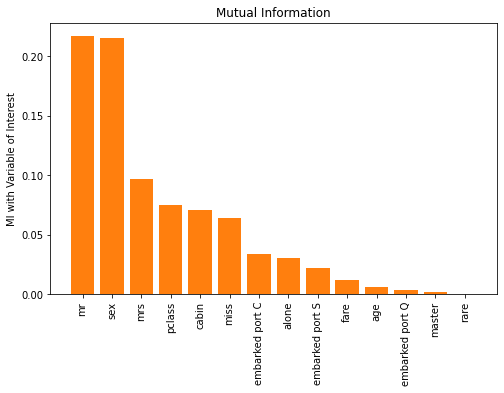

In [7]:
mi = {}
features = list(set(titanic.columns).difference(('survived',)))

for feature in features:
    mi[feature] = mutual_information(prob(titanic[['survived', feature]].values), 1)

plot_mi(mi)

The next cell plots the values of MI and CMI for all features and three-variable permutations. Notice the clustering of values in tight ranges of values:

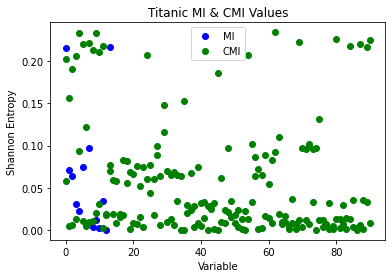

In [8]:
plt.plot(range(len(features)), [mutual_information(prob(titanic[['survived', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("Titanic MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])

Notice the high number of valid solutions that form a small cluster (the energy difference between the five best solutions in the depicted graph is in the fourth decimal place). Neuromorphic computing's strength is in quickly finding diverse good solutions to hard problems, it is not best employed as a double-precision numerical calculator. Run naively on this dataset, it finds numerous good solutions but is unlikely to find the exact optimal solution.

## Building the MI-Based BQM

Select 8 features with the top MI ranking found above:

In [9]:
keep = 8

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
titanic = titanic[[column[0] for column in sorted_mi[0:keep]] + ["survived"]]
features = list(set(titanic.columns).difference(('survived',)))

print("Submitting for {} features: {}".format(keep, features))

Submitting for 8 features: ['sex', 'cabin', 'miss', 'alone', 'pclass', 'mrs', 'embarked port C', 'mr']


Calculate a BQM based on the problem's MI and CMI :

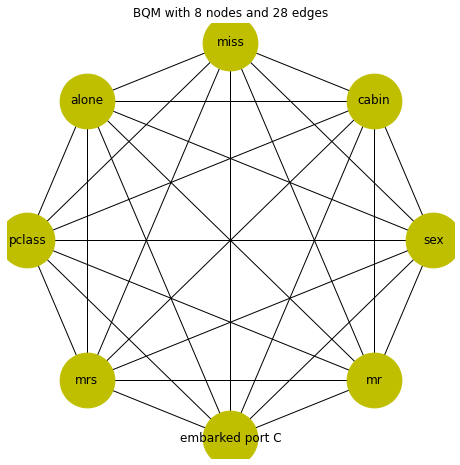

In [10]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(titanic[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()  

plot_bqm(bqm)

##  Setting Up Dynex as a Sampler

Set up a Dynex Annealer as your sampler in the standard way described in the Dynex SDK documentation's Configuring Access to the Dynex Platform.

##  Submit the Problem for All k Values

For all numbers of selected features, k, set a $\left(\frac{n}{k}\right)$ penalty, submit an updated BQM for solution. In this example we will be using 256 reads, which means we are running the sampling problem on 256 individual Dynex Chips with different initial conditions for a period of 1000 integration time steps:

In [12]:
selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    # Dynex Sampler:
    model = dynex.BQM(kbqm);
    sampler = dynex.DynexSampler(model);
    
    # Map the result to the variables:
    sampleset = sampler.sample(num_reads=256, annealing_time = 1000);
    sample = {};
    i = 0;
    for var in sampler.var_mappings:
        if float(sampleset[-1]['sample'][i]) < 0:
            sample[var] = 0;
        else:
            sample[var] = 1;
        i = i + 1
    
    for fi, f in enumerate(features):
        selected_features[k-1, fi] = sample[f] # best[f]


time: 0.04s #workers: 1 #chips: 256 #steps: 1000 global falsified softs: 6 global energy: 26768.0
FINISHED READ AFTER 0.04 SECONDS
SAMPLESET LOADED


Plot the selected features:

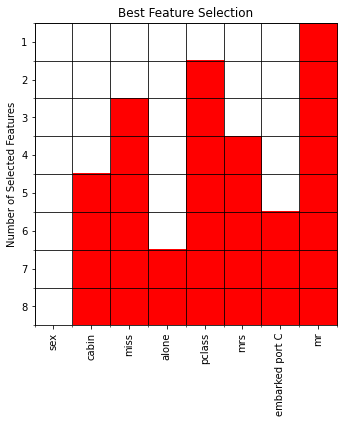

In [13]:
plot_feature_selection(features, selected_features);